In [1]:
import pandas
import h5py
import json
import os
import numpy
import yaml
from wm_utility.wm_recipe_utility import lookup_population_in_recipe

# Path to a pixel-to-pixel connectivity result
# Use scripts/count_adjacent_connectivity.py in https://bbpgitlab.epfl.ch/conn/configs/thalamo-neocortex-connectivity
# Use it without option -f, but add option -p projection_name
fn_model = "/gpfs/bbp.cscs.ch/project/proj83/scratch/home/reimann/connectome_analysis/Bio_M_20200805/total_synapse_counts/adjacent_connection_counts_exc_wm.pkl"
fn_recipe = "./data/rat_wm_recipe_tr_ll_ul_un_n_m_subtract_adjacents.yaml"

counts_lcl = pandas.read_pickle(fn_model)
valid = numpy.all(counts_lcl[["Source region", "Target region"]] != "INH", axis=1)
counts_lcl = counts_lcl["Density"][valid]
prescr = counts_lcl.copy()
prescr[:] = 0.0

with open(fn_recipe, "r") as fid:
    recipe = yaml.load(fid, Loader=yaml.SafeLoader)

display(counts_lcl)

Source region  Target region
S1DZ           S1DZ             0.002582
               S1FL,S1Sh        0.011206
               S1HL             0.011649
               S1J,S1DZO        0.005649
               S1Tr             0.004365
               S1ULp            0.038002
S1FL,S1Sh      S1DZ             0.008034
               S1FL,S1Sh        0.001113
               S1HL             0.033943
               S1J,S1DZO        0.012264
               S1Tr             0.008597
               S1ULp            0.020868
S1HL           S1DZ             0.011986
               S1FL,S1Sh        0.019203
               S1HL             0.001838
               S1J,S1DZO        0.000344
               S1Tr             0.018282
               S1ULp            0.000079
S1J,S1DZO      S1DZ             0.005384
               S1FL,S1Sh        0.007211
               S1HL             0.000248
               S1J,S1DZO        0.001263
               S1Tr             0.000151
               S1ULp        

In [5]:
for proj in recipe["projections"]:
    src = proj["source"]
    rat_src = lookup_population_in_recipe(src, recipe)
    src_str = ",".join(rat_src)
    for tgt in proj["targets"]:
        v = float(tgt["density"])
        rat_tgt = lookup_population_in_recipe(tgt["population"], recipe)
        tgt_str = ",".join(rat_tgt)
        prescr[src_str, tgt_str] += v
display(prescr)

Source region  Target region
S1DZ           S1DZ             0.000000
               S1FL,S1Sh        0.010001
               S1HL             0.015521
               S1J,S1DZO        0.005507
               S1Tr             0.005141
               S1ULp            0.036441
S1FL,S1Sh      S1DZ             0.009387
               S1FL,S1Sh        0.000000
               S1HL             0.052276
               S1J,S1DZO        0.019832
               S1Tr             0.010145
               S1ULp            0.040467
S1HL           S1DZ             0.014611
               S1FL,S1Sh        0.028740
               S1HL             0.000000
               S1J,S1DZO        0.000000
               S1Tr             0.025971
               S1ULp            0.000000
S1J,S1DZO      S1DZ             0.003706
               S1FL,S1Sh        0.011163
               S1HL             0.000000
               S1J,S1DZO        0.000000
               S1Tr             0.000000
               S1ULp        

In [6]:
regions_sscx = prescr.index.levels[0].values.tolist()
if "INH" in regions_sscx:
    regions_sscx.pop(regions_sscx.index("INH"))
cmat_local = numpy.zeros((len(regions_sscx), len(regions_sscx)))
cmat_presc = numpy.zeros((len(regions_sscx), len(regions_sscx)))

for i, reg in enumerate(regions_sscx):
    for j, reg2 in enumerate(regions_sscx):
        if (reg, reg2) in counts_lcl:
            cmat_local[i, j] = counts_lcl[reg, reg2]
        if (reg, reg2) in prescr:
            cmat_presc[i, j] = prescr[reg, reg2]
    

[Text(0, 0, 'S1DZ'),
 Text(0, 1, 'S1FL,S1Sh'),
 Text(0, 2, 'S1HL'),
 Text(0, 3, 'S1J,S1DZO'),
 Text(0, 4, 'S1Tr'),
 Text(0, 5, 'S1ULp')]

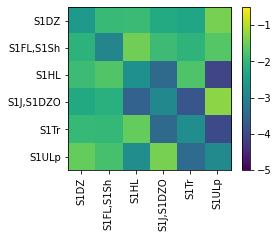

In [7]:
from matplotlib import pyplot as plt
use_clim = [-5, -0.5]
ax = plt.figure(figsize=(4, 3)).gca()
img = ax.imshow(numpy.log10(cmat_local + 1E-5))
img.set_clim(use_clim)
plt.colorbar(img)

ax.set_xticks(range(len(regions_sscx)))
ax.set_xticklabels(regions_sscx, rotation='vertical')
ax.set_yticks(range(len(regions_sscx)))
ax.set_yticklabels(regions_sscx)


[Text(0, 0, 'S1DZ'),
 Text(0, 1, 'S1FL,S1Sh'),
 Text(0, 2, 'S1HL'),
 Text(0, 3, 'S1J,S1DZO'),
 Text(0, 4, 'S1Tr'),
 Text(0, 5, 'S1ULp')]

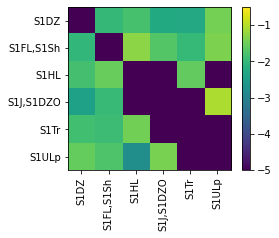

In [8]:
ax = plt.figure(figsize=(4, 3)).gca()
img = ax.imshow(numpy.log10(cmat_presc + 1E-5))
img.set_clim(use_clim)
plt.colorbar(img)

ax.set_xticks(range(len(regions_sscx)))
ax.set_xticklabels(regions_sscx, rotation='vertical')
ax.set_yticks(range(len(regions_sscx)))
ax.set_yticklabels(regions_sscx)

[Text(0, 0, 'S1DZ'),
 Text(0, 1, 'S1FL,S1Sh'),
 Text(0, 2, 'S1HL'),
 Text(0, 3, 'S1J,S1DZO'),
 Text(0, 4, 'S1Tr'),
 Text(0, 5, 'S1ULp')]

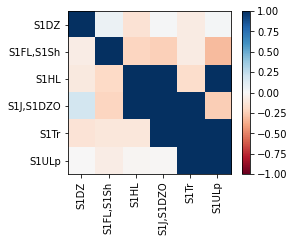

In [12]:
rel_error = (cmat_local - cmat_presc) / (cmat_local + cmat_presc)
ax = plt.figure(figsize=(4, 3)).gca()
img = ax.imshow(rel_error, cmap="RdBu")
img.set_clim([-1, 1])
plt.colorbar(img)

ax.set_xticks(range(len(regions_sscx)))
ax.set_xticklabels(regions_sscx, rotation='vertical')
ax.set_yticks(range(len(regions_sscx)))
ax.set_yticklabels(regions_sscx)

[Text(0, 0, 'S1DZ'),
 Text(0, 1, 'S1FL,S1Sh'),
 Text(0, 2, 'S1HL'),
 Text(0, 3, 'S1J,S1DZO'),
 Text(0, 4, 'S1Tr'),
 Text(0, 5, 'S1ULp')]

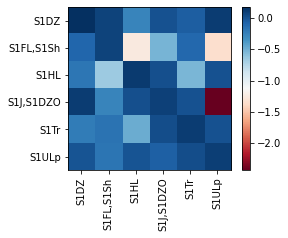

In [13]:
rel_error = (cmat_local - cmat_presc) / cmat_presc.mean()
ax = plt.figure(figsize=(4, 3)).gca()
img = ax.imshow(rel_error, cmap="RdBu")
plt.colorbar(img)

ax.set_xticks(range(len(regions_sscx)))
ax.set_xticklabels(regions_sscx, rotation='vertical')
ax.set_yticks(range(len(regions_sscx)))
ax.set_yticklabels(regions_sscx)